In [1]:
%matplotlib widget

import os
import numpy as np
from skimage import transform, filters
import tomopy
import svmbir
import dxchange
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed, FloatSlider, IntSlider
import ALS_recon_helper

astropy module not found
olefile module not found


#### Choose File
###### Here we choose and Petiole data

In [2]:
#input and output paths
dataDir = "//global/cfs/cdirs/als/users/dperl/petiole_data"
outputDir = "/global/cscratch1/sd/dperl/tomo_data"
filename = '20211222_113313_petiole3.h5'

In [3]:
path = os.path.join(dataDir, filename)
metadata = ALS_recon_helper.read_metadata(path)

OSError: [Errno 524] Unable to open file (unable to lock file, errno = 524, error message = 'Unknown error 524')

##### Get projection data. Can subsample angles and/or slices with numpy slicing notation (start, stop, step)
###### Here we highly downsample a single slice for quick reconstruction 

In [ ]:
# angles_ind = None # get all angles (implicitly)
# angles_ind = slice(0,-1,1) # get all angles (explicitly)
angles_ind = slice(0,-1,8) # get every 8th angle
# slices_ind =  None # get all slices
# slices_ind = slice(0,10,1) # get first 10 slices
# slices_ind = slice(-10,-1,1) # get last 10 slices
slices_ind = slice(metadata['numslices']//2,metadata['numslices']//2+1,1) # get only middle slice
#downsample_factor = None # do not downsample projections
downsample_factor = 8 # downsample projections (in both slice and ray dimensions)
tomo, angles = ALS_recon_helper.read_data(path, proj=angles_ind, sino=slices_ind, downsample_factor=downsample_factor)
print(f"data shape = {tomo.shape}")

#### Reconstruct 2D slice with manual center of rotation (COR) 
###### Here we try many CORs to find best one. Iterate COR range with increasing resolution

In [ ]:
%%time
# cors = np.arange(-80,81,downsample_factor) # wide COR range -- minimum detectable difference = downsampled_factor
cors = np.arange(32,41,downsample_factor) # narrow COR range -- minimum detectable difference = downsampled_factor
recons = [tomopy.recon(tomo, angles, center=cor/downsample_factor + tomo.shape[2]/2,
                       algorithm=tomopy.astra,
                       options={'method':"FBP", 'proj_type':'linear'})
          for cor in cors]

###### Gaussian smooth recons (FBP is noisy)

In [27]:
recons = [filters.gaussian(recon,sigma=0.5) for recon in recons]

In [28]:
def plot_recon(recon,fignum=1):
    img_lim = [np.percentile(recons[0],1),np.percentile(recons[0],99)]
    if plt.fignum_exists(fignum): plt.close(fignum)
    fig = plt.figure(num=fignum,figsize=(6, 6))
    axs = plt.gca()
    h = axs.imshow(recon[0],cmap='gray',vmin=img_lim[0],vmax=img_lim[1])    
    return h, axs
def set_cor(i):
    h.set_data(recons[i][0])
    axs.set_title(f"COR = {cors[i]} pixels (at full res)")

interactive(children=(IntSlider(value=0, description='i', max=1), Output()), _dom_classes=('widget-interact',)…

<function __main__.set_cor(i)>

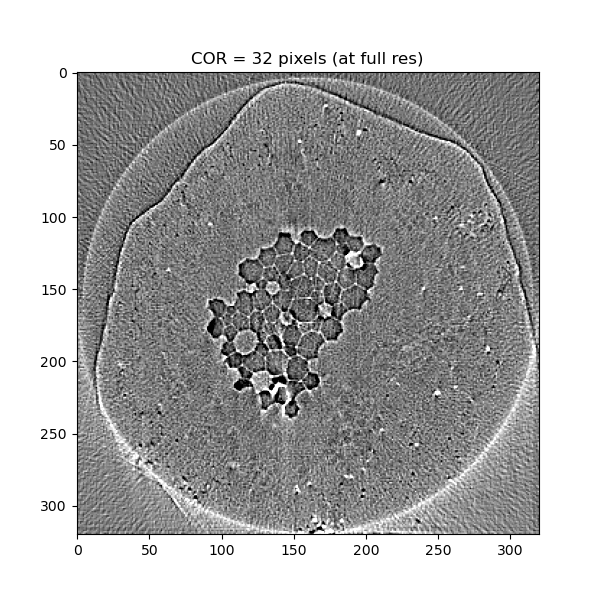

In [29]:
h, axs = plot_recon(recons[0],fignum=1)
interact(set_cor, i=IntSlider(min=0, max=len(cors)-1, step=1, value=0))

#### Reconstruct 2D slice at full resolution with best COR 
###### Here we try many CORs to find best one

In [30]:
%%time
angles_ind = None # get all angles
slices_ind = slice(metadata['numslices']//2,metadata['numslices']//2+1,1) # get only middle slice
downsample_factor = None # do not downsample projections
COR = 36.5 # need to multiply COR by old downsampling factor  
tomo, angles = ALS_recon_helper.read_data(path, proj=angles_ind, sino=slices_ind, downsample_factor=downsample_factor)
fbp_recon = tomopy.recon(tomo, angles, center=COR + tomo.shape[2]/2,
                       algorithm=tomopy.astra,
                       options={'method':"FBP", 'proj_type':'linear'})
print(fbp_recon.shape)

(1, 2560, 2560)
CPU times: user 1min 45s, sys: 239 ms, total: 1min 45s
Wall time: 1min 48s


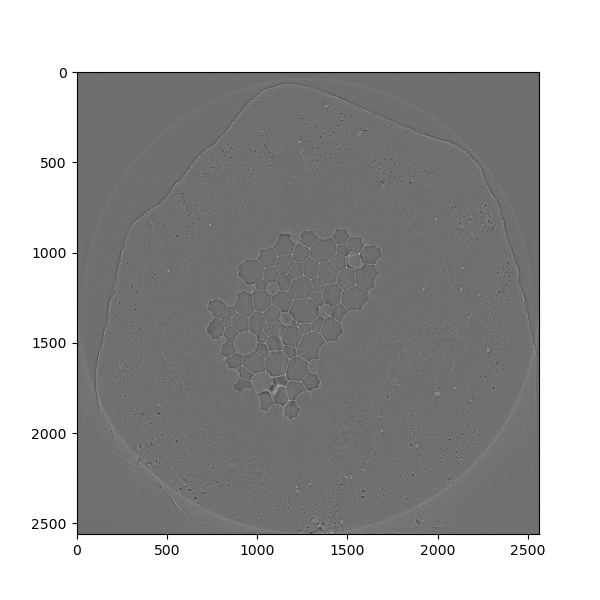

In [31]:
if plt.fignum_exists(2): plt.close(2)
plt.figure(num=2,figsize=(6,6))
plt.imshow(fbp_recon[0],cmap='gray')

In [ ]:
%%time
T = 0.1 #smoothing parameter
q = 2 #smoothing parameter
p = 1.2 #smoothing parameter
sharpness = 0.5
snr_db = 40.0
angles_ind = None # get all angles
slices_ind = slice(metadata['numslices']//2,metadata['numslices']//2+1,1) # get only middle slice
downsample_factor = None # do not downsample projections
COR = 0.0 # must use COR = 0.0
tomo, angles = ALS_recon_helper.read_data(path, proj=angles_ind, sino=slices_ind, downsample_factor=downsample_factor)

angles = np.linspace(0,np.pi,1313) # must use these angles -- dxchange angles are infinitesimally different for some reason

svmbir_recon = svmbir.recon(tomo,angles,
                      center_offset=COR,
                      init_image=fbp_recon, # initialize with fbp for faster convergence                        
                      T=T, q=q, p=p, sharpness=sharpness, snr_db=snr_db,
                      num_threads=8,
                      verbose=2,
                      svmbir_lib_path='/global/cscratch1/sd/dperl/svmbir_cache', object_name='object')
print(recon.shape)

In [ ]:
if plt.fignum_exists(3): plt.close(3)
fig, axs = plt.subplots(num=3,figsize=(8,6))
axs[0].imshow(fbp_recon[0],cmap='gray')
axs[0].set_title('FBP')
axs[1].imshow(svmbir_recon[0],cmap='gray')
axs[1].set_title('SVMBIR')

In [ ]:
# submit batch job